# **Predicting the popularity level of a song from various song metrics**

## Including all the needed libraries:



In [164]:
import pandas as pd
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats

## Reading the data table:

The table I chose is designed to predict the music genre of a song based on its features. However, I wanted to make it a bit more interesting and practical by focusing on predicting the song's popularity instead.

In [165]:
raw_data = pd.read_csv('../data/music_genre.csv')

## **Part 1: Data Analysis**

In this section, we will analyze the data, the target feature, and the relationships between the features.

First, we will examine the raw data as it is:

In [166]:
print(raw_data.shape)
print("\n")
print(raw_data.head())
print("\n")
print(raw_data.describe())

(50005, 18)


   instance_id           artist_name            track_name  popularity  acousticness  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0       0.00468   
1      46652.0  Thievery Corporation      The Shining Path        31.0       0.01270   
2      30097.0        Dillon Francis             Hurricane        28.0       0.00306   
3      62177.0              Dubloadz                 Nitro        34.0       0.02540   
4      24907.0           What So Not      Divide & Conquer        32.0       0.00465   

   danceability  duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0         0.652         -1.0   0.941           0.79200  A#     0.115    -5.201  Minor   
1         0.622     218293.0   0.890           0.95000   D     0.124    -7.043  Minor   
2         0.620     215613.0   0.755           0.01180  G#     0.534    -4.617  Major   
3         0.774     166875.0   0.700           0.00253  C#     0.157    -4.498  Major   
4         0.

We can see that the dataset consists of 50,000 samples and 18 features, which can be divided into the following groups:

In [167]:
id_features = ['instance_id', 'artist_name', 'track_name']
num_features = ['acousticness',  'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'popularity']
cat_features = ['key', 'mode', 'obtained_date', 'music_genre']
target_feature = ['popularity']



* ID_Features: Features used solely for identifying instances, which are not relevant to our analysis.
* Num_Features: The numerical attributes in the dataset.
* Cat_Features: The categorical attributes in the dataset.
* Target_Feature: The feature we aim to predict.



### **1'st visualization:**

The distribution of the target feature in the dataset.

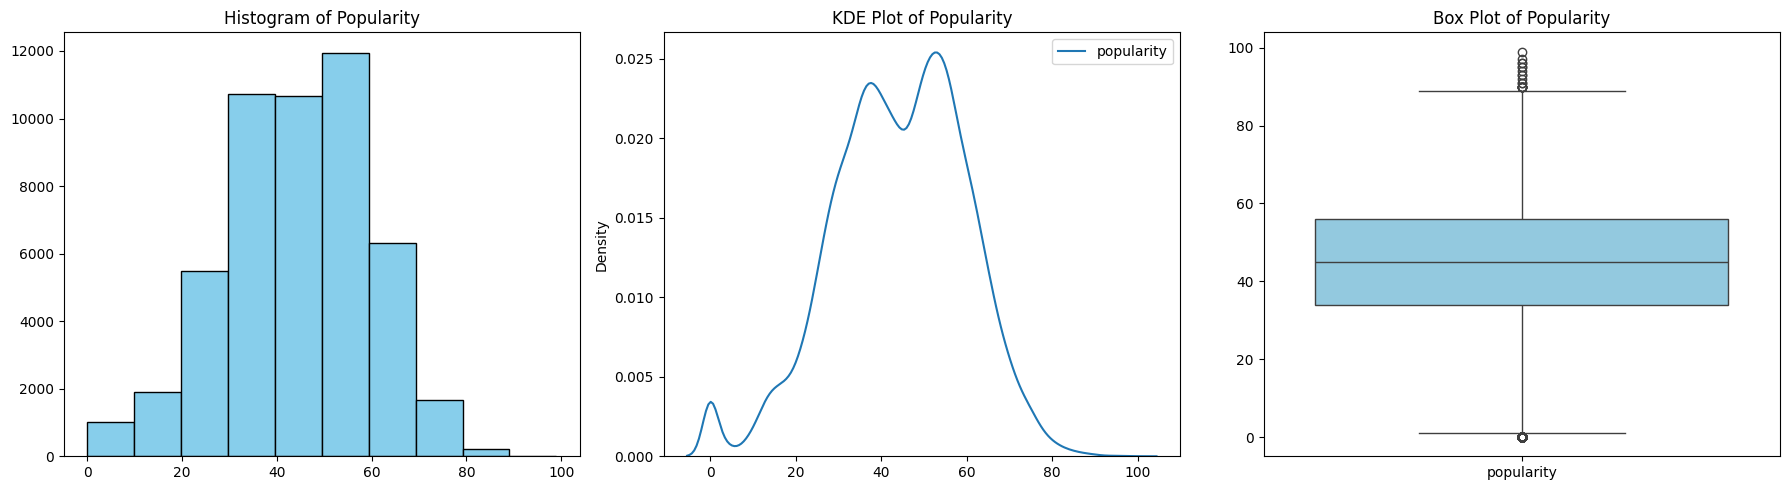

In [168]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(raw_data[target_feature], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Popularity')

sns.kdeplot(raw_data[target_feature], ax=axes[1], color='blue')
axes[1].set_title('KDE Plot of Popularity')

sns.boxplot(raw_data[target_feature], ax=axes[2], color='skyblue')
axes[2].set_title('Box Plot of Popularity')

plt.tight_layout()
plt.show()

From these graphs, we can extract various statistical insights about the target feature. Overall, we can observe that, in the given dataset, the target feature is approximately normally distributed. This plot is particularly important because understanding the target feature is a crucial part of working with data for machine learning.

Although I have presented three graphs, we will treat them as a single visualization since they convey the same information in different ways.

### **2'nd visualization:**

Correlation between the numerical features.

In this block, we observe that the tempo feature contains non-numeric, non-NaN values. I am cleaning the data by converting these values to NaN. This step is necessary for the next visualization to work and will be explained in the preprocessing section of the next part.

In [169]:
non_numeric_rows = raw_data[pd.to_numeric(raw_data['tempo'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['tempo'])['tempo'].count())
raw_data["tempo"] = pd.to_numeric(raw_data["tempo"], errors="coerce")

,tempo
tempo,
?,4980


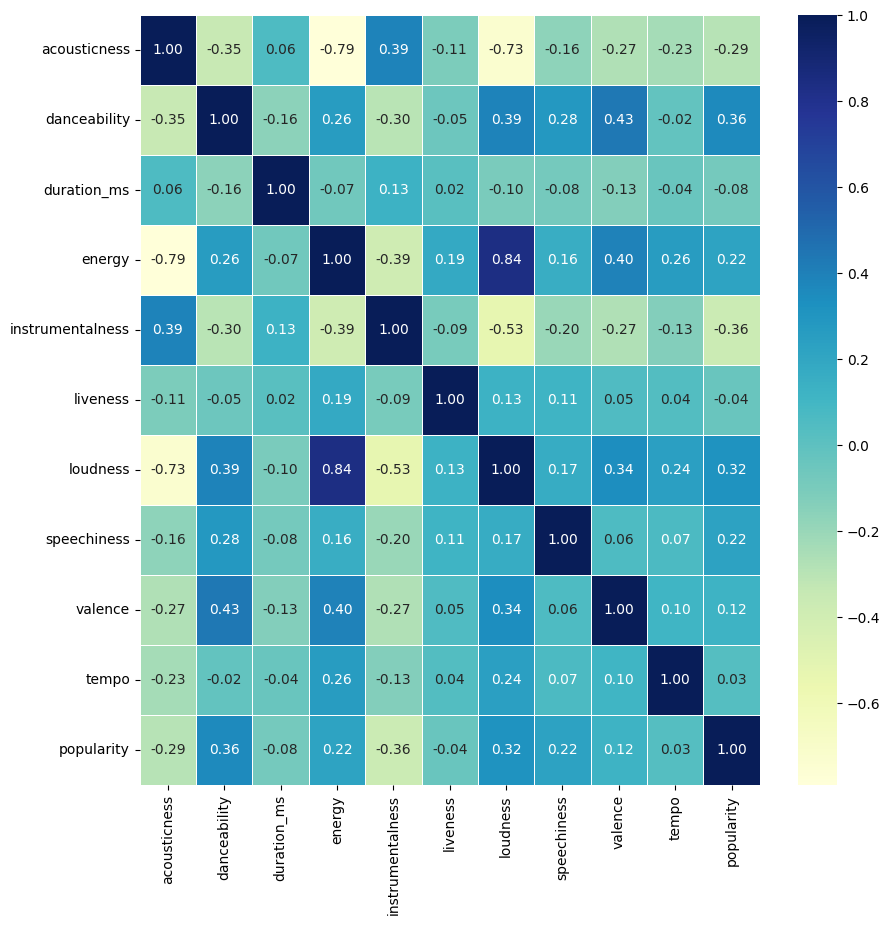

In [170]:
num_only_corr = raw_data[num_features].corr(method="pearson")
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(num_only_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)
plt.show()

In this graph, we can see the correlation between all the numerical features in the dataset. From this, we learn that the target feature, popularity, is not strongly correlated with any of the features. Additionally, we observe that the loudness and energy features are highly correlated, while acousticness and energy are negatively correlated (which aligns with real-world expectations).

This plot is useful because correlation serves as a good indicator of the relationship between the target feature and the other features.

### **3'rd visualization:**

Distribution of Popularity by Music Genre

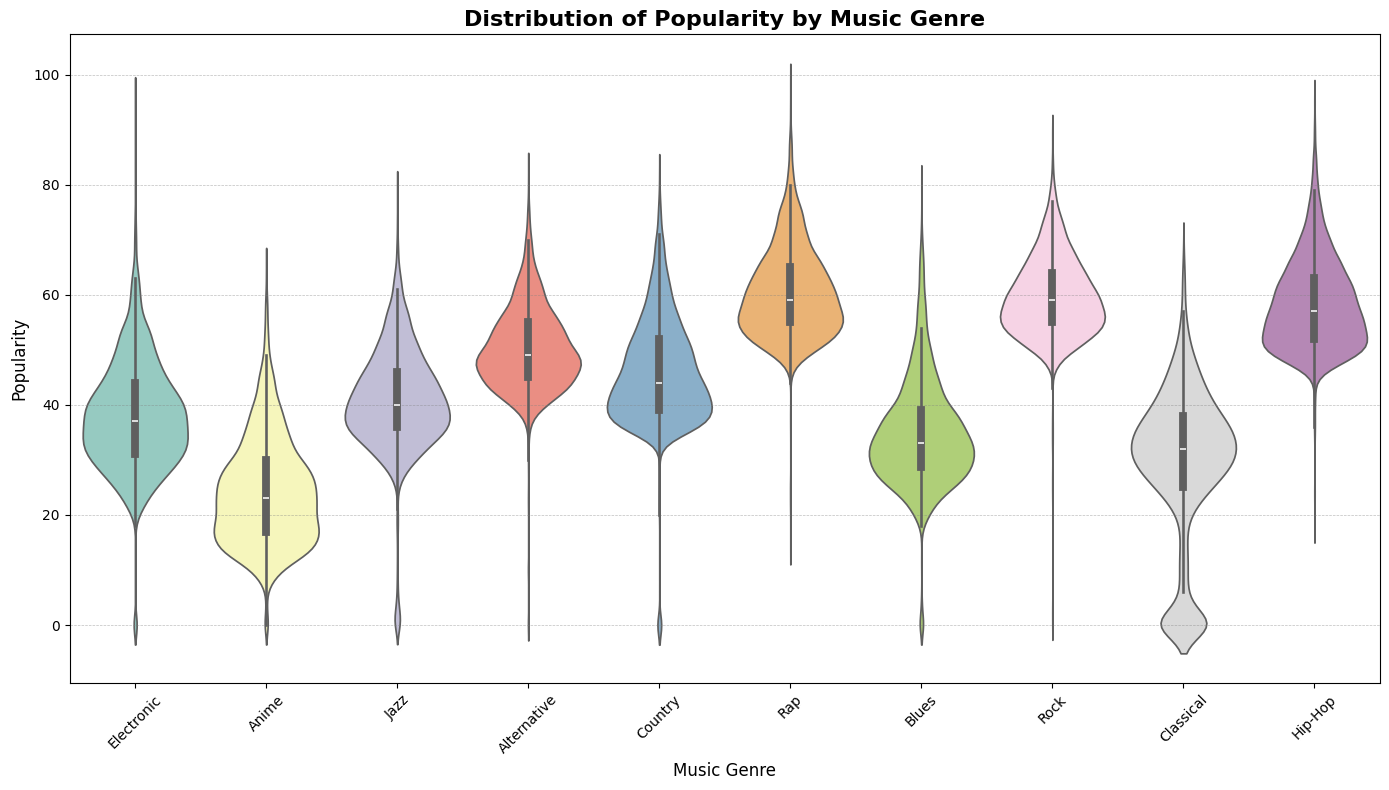

In [171]:
plt.figure(figsize=(14, 8))

sns.violinplot(x=raw_data['music_genre'], y=raw_data['popularity'], hue=raw_data['music_genre'], palette='Set3', dodge=False, legend=False)

plt.title('Distribution of Popularity by Music Genre', fontsize=16, fontweight='bold')
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Popularity', fontsize=12)

plt.xticks(rotation=45)

plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()


In this visualization, we can see the popularity of each music genre. It's clear that Hip-Hop, Rock, and Rap (which are currently the most popular genres) have the highest popularity scores. This plot not only highlights the most popular genres but also allows us to observe trends and patterns in genre popularity. For example, we can see that certain genres may have a wider spread of popularity, while others are more concentrated around specific values. This visualization provides valuable insights into how popularity varies across genres.

**4'th visualization:**

3D Scatter Plot of Loudness, Energy, and Popularity

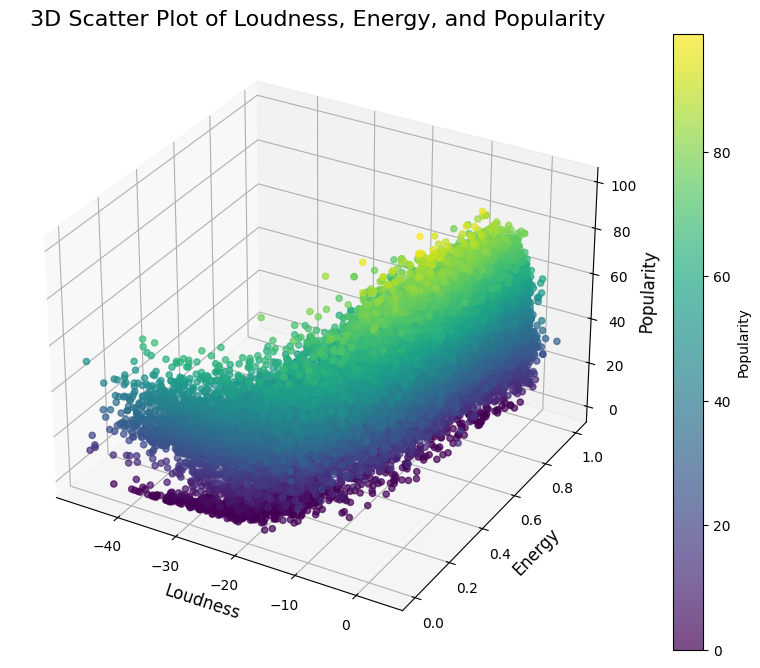

In [172]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(raw_data['loudness'], raw_data['energy'], raw_data['popularity'], c=raw_data['popularity'], cmap='viridis', marker='o', alpha=0.7)

cbar = plt.colorbar(sc)
cbar.set_label('Popularity')

ax.set_xlabel('Loudness', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_zlabel('Popularity', fontsize=12)

plt.title("3D Scatter Plot of Loudness, Energy, and Popularity", fontsize=16)
plt.show()

This plot helps us visualize the relationship between the two most correlated features: Loudness and Energy, as well as their connection to the target feature, popularity. We can observe that while Loudness and Energy are correlated, they do not seem to have a direct impact on the popularity of music. There are no popular songs with low Loudness and Energy values, but not all loud and energetic music is popular. This suggests that while these features may play a role in popularity, other factors likely contribute as well.

**5'th visualization:**

the destrebution of the duration_ms feature in the data

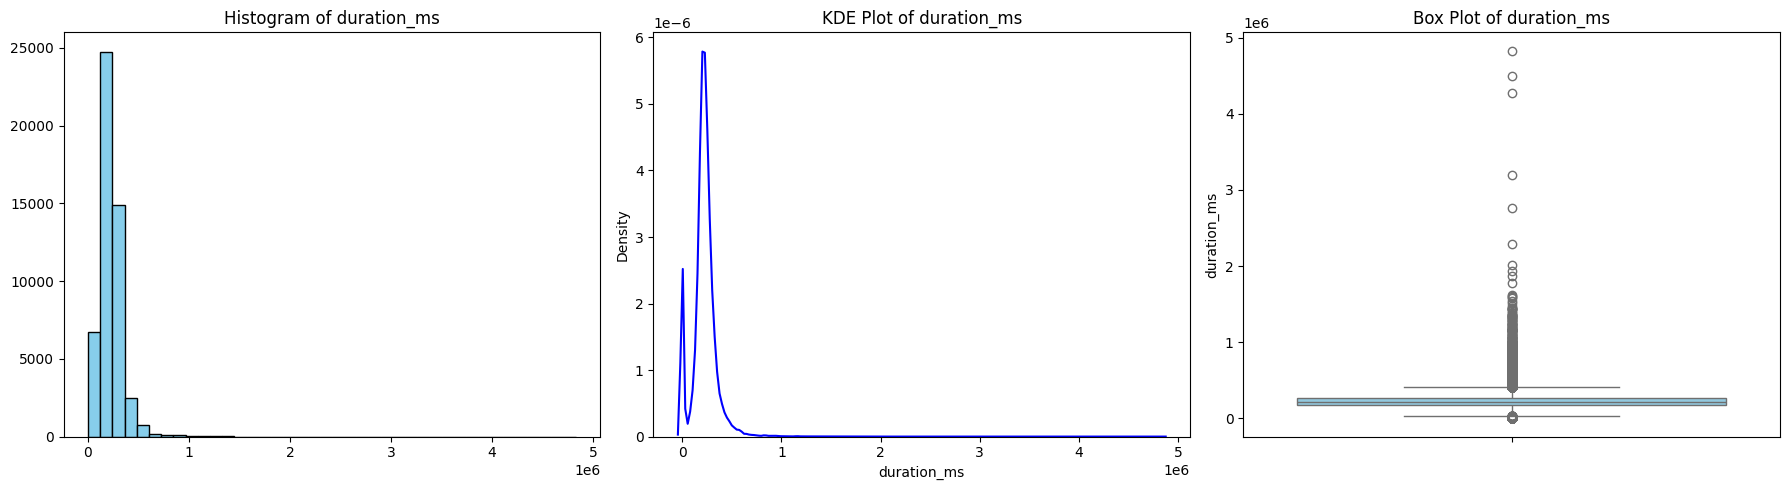

In [173]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(raw_data['duration_ms'], bins=40, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of duration_ms')

sns.kdeplot(raw_data['duration_ms'], ax=axes[1], color='blue')
axes[1].set_title('KDE Plot of duration_ms')

sns.boxplot(raw_data['duration_ms'], ax=axes[2], color='skyblue')
axes[2].set_title('Box Plot of duration_ms')

plt.tight_layout()
plt.show()

Unlike the previous visualizations that highlighted the strengths in the data and the relationships between features that could help improve the model, this plot reveals the defects in the data that may negatively impact the model's performance.

We observe that the duration_ms feature is represented by very large numbers (indicated by the "le6" notation on the axis) and has a very unusual distribution. This is because the duration of a song is not a naturally occurring value but rather a choice made by the author. This feature, being poorly normalized and somewhat irregular, could harm the model's performance.

I chose this visualization because it is crucial to identify not only the positive aspects of the data but also the problematic ones. Understanding the weaknesses in the data allows us to address these issues effectively and ultimately improve the model's performance.

## **Part 2: Basic Model Pipeline**

### 1. prepocessing

First, we want to clean the numeric features by removing any non-numeric rows. We can see that there are no such rows in the numeric features, except for the tempo feature, which we addressed in the previous section.



In [174]:
non_numeric_rows = raw_data[pd.to_numeric(raw_data['popularity'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['popularity'])['popularity'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['acousticness'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['acousticness'])['acousticness'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['danceability'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['danceability'])['danceability'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['duration_ms'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['duration_ms'])['duration_ms'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['energy'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['energy'])['energy'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['instrumentalness'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['instrumentalness'])['instrumentalness'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['liveness'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['liveness'])['liveness'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['loudness'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['loudness'])['loudness'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['speechiness'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['speechiness'])['speechiness'].count())

non_numeric_rows = raw_data[pd.to_numeric(raw_data['valence'], errors='coerce').isna()]
display(non_numeric_rows.groupby(['valence'])['valence'].count())

,popularity
popularity,


,acousticness
acousticness,


,danceability
danceability,


,duration_ms
duration_ms,


,energy
energy,


,instrumentalness
instrumentalness,


,liveness
liveness,


,loudness
loudness,


,speechiness
speechiness,


,valence
valence,


Next, we will drop the ID features, as they are not needed for prediction.

In [175]:
raw_data = raw_data.drop(id_features, axis=1)

Next, we will replace all the NaN values in the dataset with the median of each respective column.

In [176]:
raw_data = raw_data.fillna(raw_data.median(numeric_only=True))

Now, we are splitting the data into training and testing sets.

In [177]:
X = raw_data.drop('popularity', axis=1)
y = raw_data['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Lastly, we are creating the preprocessor for the pipeline by standardizing the numerical features and encoding the categorical features.

In [178]:
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### 2. model

In [179]:
model = XGBRegressor(n_estimators=100, learning_rate=0.2, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

Finally, we can fit the model and make predictions.

In [180]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

**Part 3: Error Analysis**

In [181]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Explained Variance Score (EVS): {evs:.2f}")

Root Mean Squared Error (RMSE): 9.21
R-squared (R²): 0.65
Mean Absolute Error (MAE): 6.98
Explained Variance Score (EVS): 0.65


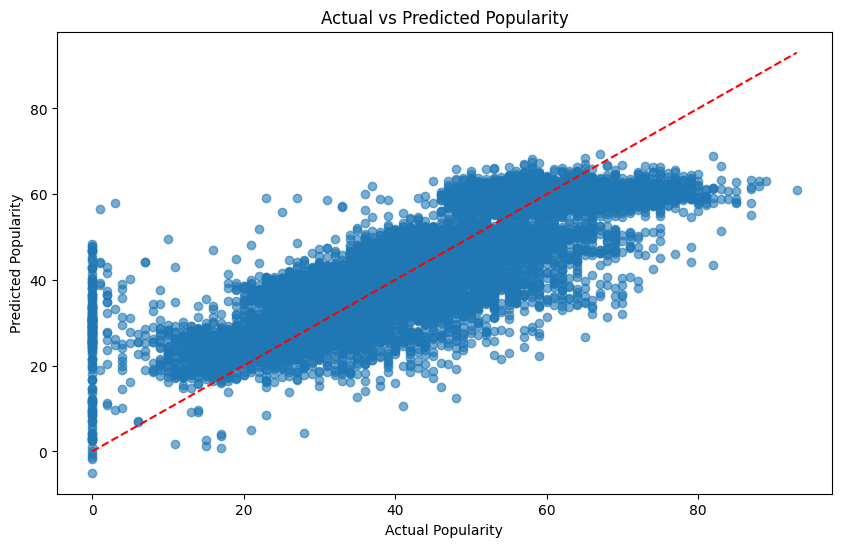

In [182]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs Predicted Popularity')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.show()

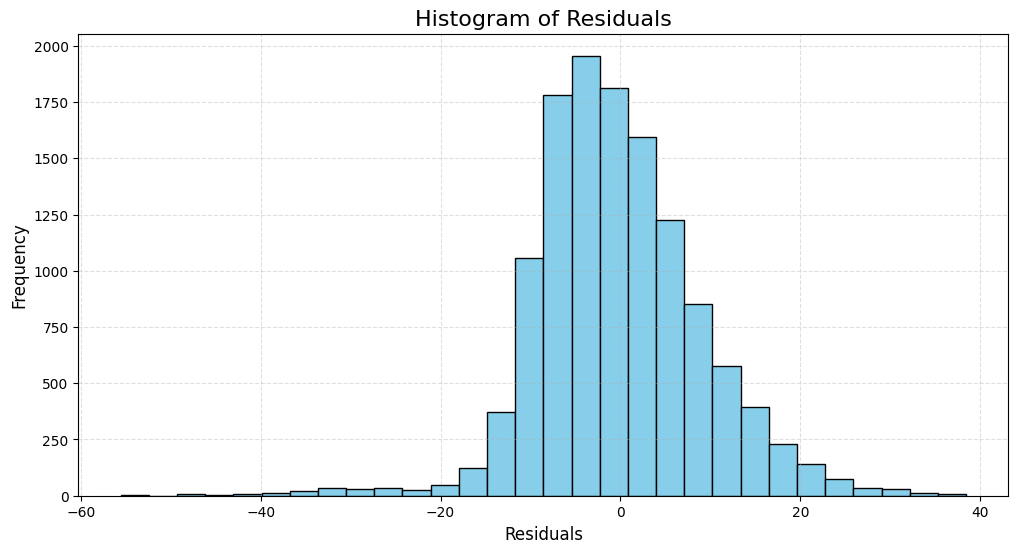

In [183]:
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.4, linestyle='--')
plt.show()

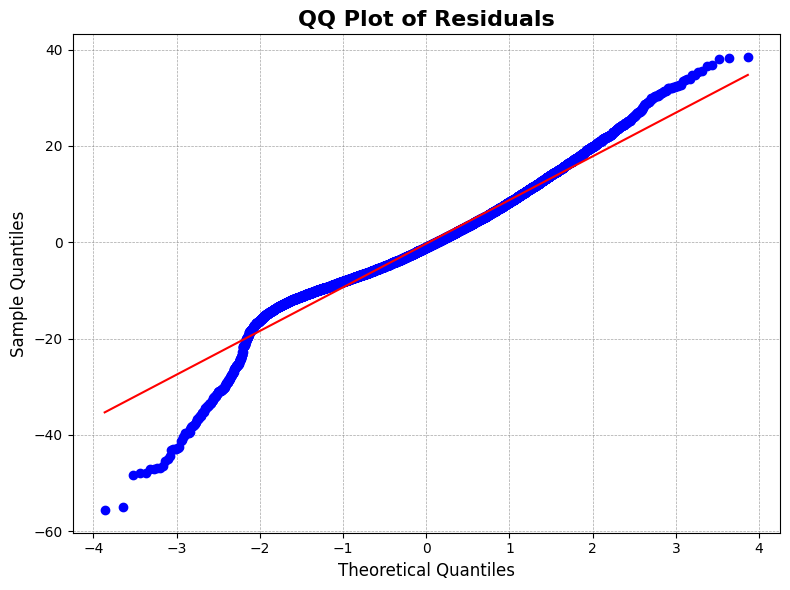

In [163]:
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)

plt.title("QQ Plot of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Above, we can see multiple errors and plots that help us understand the goodness of fit. Overall, we observe that the model performs fairly well. It can be seen that the estimates generally follow the trend of the actual data, and the residuals are approximately normally distributed.

From the "Actual vs. Predicted Popularity" plot, we can infer that the model struggles with estimating values around 0. This error may be caused by the encoding of categorical features, which introduces many zeros and ones into the data.

The same plot also reveals that for lower popularity values, the model tends to overestimate (especially for popularity values near 0). However, as popularity increases, the model starts to underestimate, which becomes evident around a popularity of 65 and above.

In the current pipeline, I suspect that the categorical features negatively impact the model and hinder its performance. Additionally, I am not entirely confident about the role of the duration_ms feature, which may also be causing issues.